In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.utils.plotting import plot_series
import warnings
warnings.filterwarnings('ignore')

In [2]:
air = pd.read_csv("AirPassengers.csv", index_col=0)
idx = pd.to_datetime(air.index ,dayfirst=True).to_period("M")
air.index = idx
air.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


(132,) (12,)


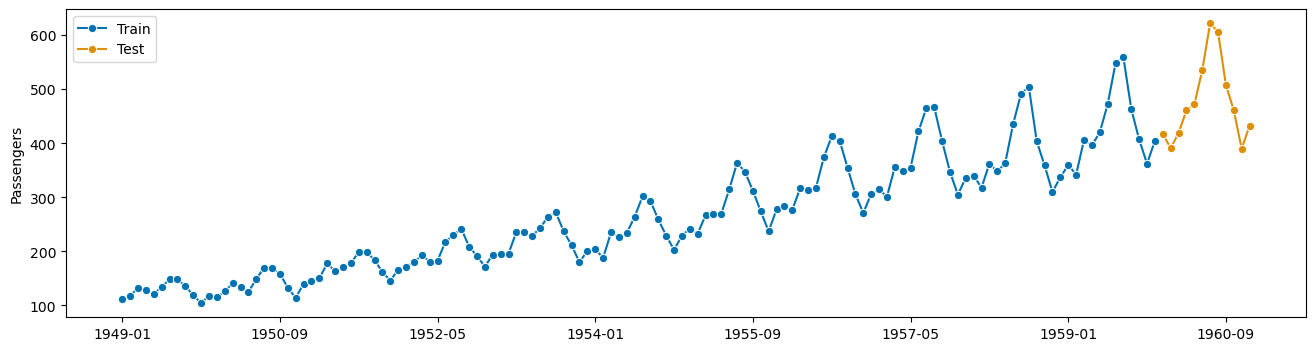

In [3]:
y = air['Passengers']
y_train, y_test = temporal_train_test_split(y,test_size=12)
print(y_train.shape, y_test.shape)
plot_series(y_train, y_test, labels=["Train", "Test"])
plt.show()

In [4]:
fh = np.arange(1, len(y_test) + 1)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [5]:
regressor = RandomForestRegressor(random_state=23)
forecaster = make_reduction(regressor,window_length=10)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
rmse = MeanSquaredError(square_root=True)
print(rmse(y_test, y_pred))

111.23745071542528


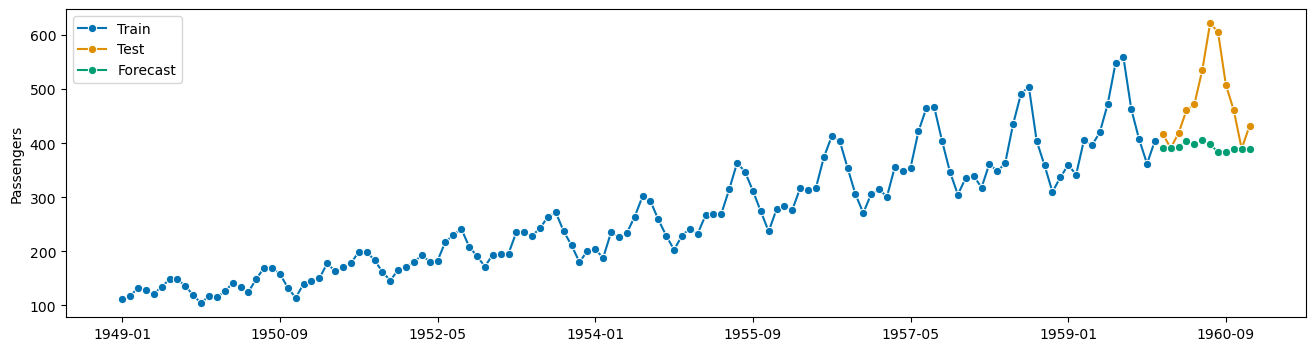

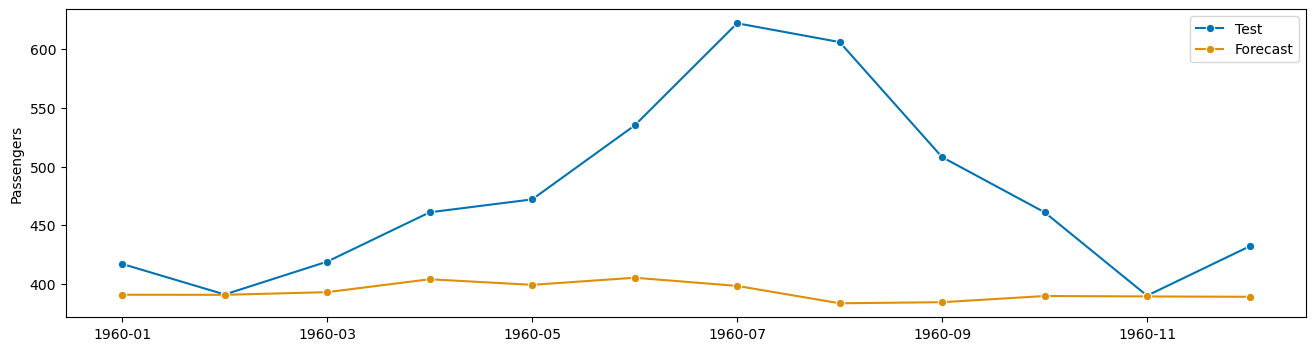

In [6]:
plot_series(y_train,y_test,y_pred , labels=['Train','Test','Forecast'])
plt.show()
plot_series(y_test,y_pred , labels=['Test','Forecast'])
plt.show()

## Basic Grid Search

In [7]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

In [8]:
forecaster = make_reduction(regressor, strategy="recursive")
params = {"window_length": [7, 10, 12, 15]}

We fit the forecaster on an initial window which is 80% of the historical data. Then use temporal sliding window cross-validation to find the optimal hyper-parameters.

In [9]:
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8))
gscv = ForecastingGridSearchCV( forecaster, strategy="refit", cv=cv, param_grid=params)
gscv.fit(y_train)
y_pred = gscv.predict(fh)
print(gscv.best_params_)
print(gscv.best_score_)

{'window_length': 12}
0.06527377521613827


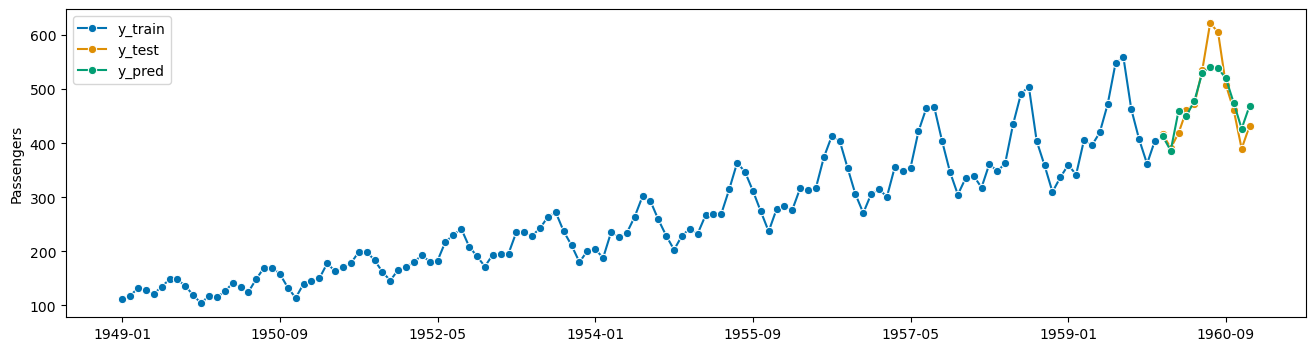

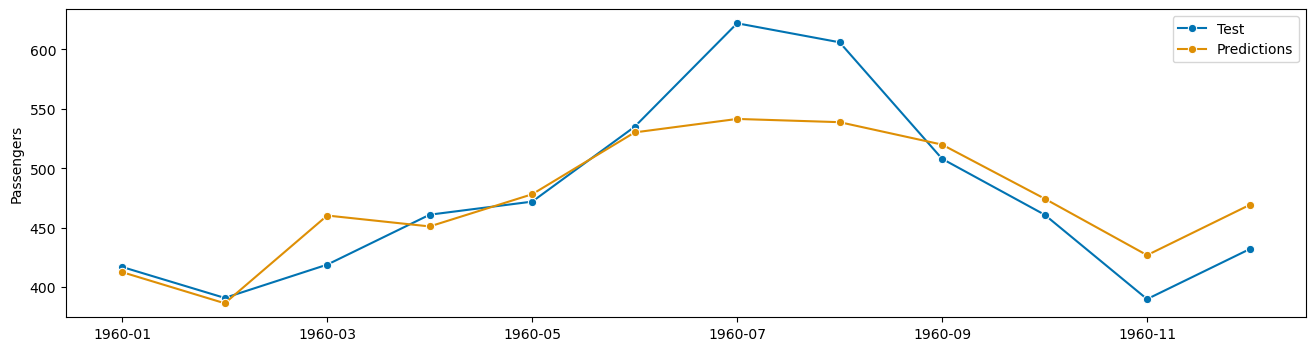

In [10]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()
plot_series(y_test, y_pred, labels=["Test", "Predictions"])
plt.show()

In [11]:
rmse = MeanSquaredError(square_root=True)
print(rmse(y_test, y_pred))

36.473433710944555


## Composite Grid Search

In [12]:
params = {"window_length": [7,10, 12, 15],
              'estimator__max_features':['auto', 'sqrt', 'log2']}
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8))
gscv = ForecastingGridSearchCV( forecaster, strategy="refit", cv=cv, param_grid=params)
gscv.fit(y_train)
y_pred = gscv.predict(fh)
print(gscv.best_params_)
print(gscv.best_score_)

{'estimator__max_features': 'sqrt', 'window_length': 12}
0.045648414985590705


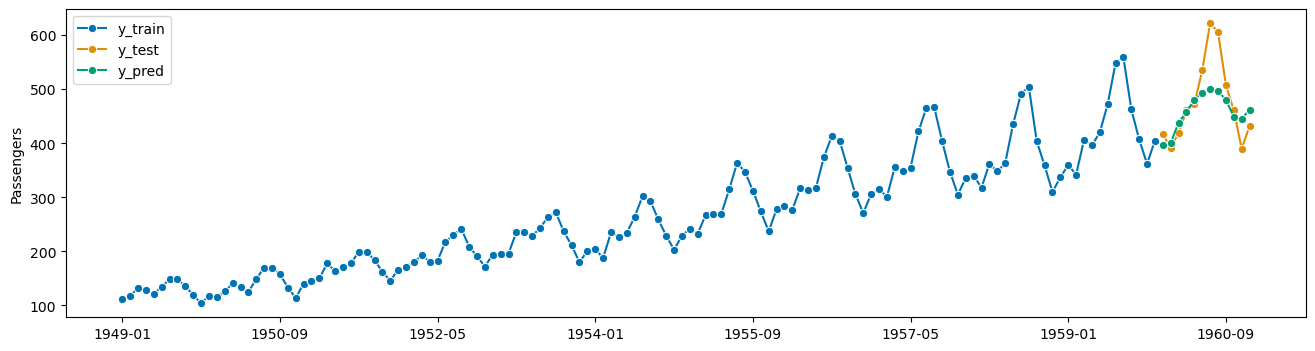

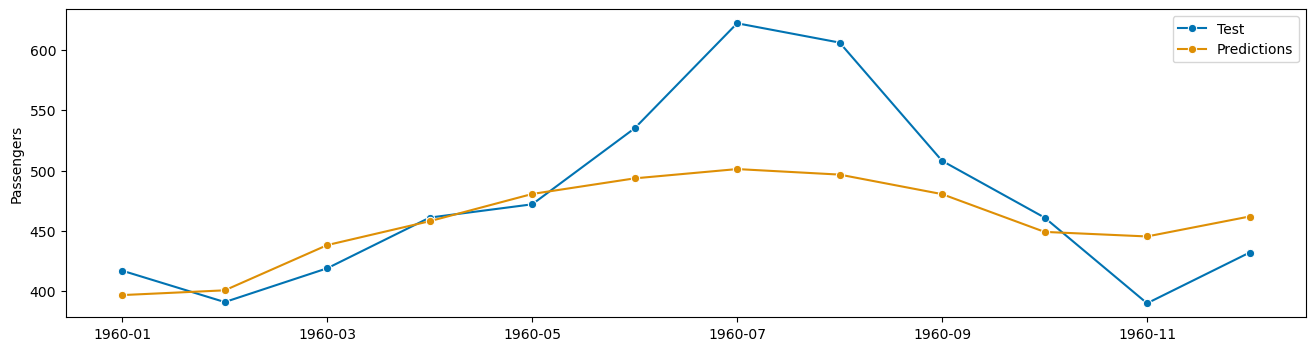

In [13]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()
plot_series(y_test, y_pred, labels=["Test", "Predictions"])
plt.show()

In [14]:
rmse = MeanSquaredError(square_root=True)
print(rmse(y_test, y_pred))

53.30177053031791
